### Paid Search Bid Optimization 

Question on Paid Search Bid Optimization(There are 4 parts )

A travel services firm has a paid search campaign. Among the many keywords in its campaign, we have data on four keywords, denoted by kw8322228, kw8322392, kw8322393 and kw8322445. These are generic, non-branded keywords, where the prospect's query does not indicate that he/she is leaning toward a specific brand. For each keyword, the firm tried several bid values and recorded the corresponding number of clicks that it received!

_**Note: Alpha should be between 70 and 76, beta should between 0.03 and 0.06, with a residual-sum-of-squares of about 230.**_

Step1: Estimate the alpha and beta for a keyword - you need to nonlinear regression. Curve fitting through scipy.optimize.curve_fit.

Step2:

In [1]:
import pandas as pd
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
from flax import linen as nn
from functools import partial
from jax import value_and_grad
from sklearn.metrics import root_mean_squared_error
ClStreamD01pd=pd.read_csv("./Data/clicksdata.kw8322228.csv")
ClStreamD02pd=pd.read_csv("./Data/clicksdata.kw8322392.csv")
ClStreamD03pd=pd.read_csv("./Data/clicksdata.kw8322393.csv")
ClStreamD04pd=pd.read_csv("./Data/clicksdata.kw8322445.csv")
alphSeries = jnp.linspace(90,100,20)
betaeries = jnp.linspace(0,0.5,100)

Metal device set to: Apple M3 Pro

systemMemory: 18.00 GB
maxCacheSize: 6.00 GB



W0000 00:00:1744941325.495566  328620 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1744941325.508341  328620 service.cc:145] XLA service 0x136564d10 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744941325.508360  328620 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1744941325.510032  328620 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1744941325.510039  328620 mps_client.cc:384] XLA backend will use up to 12884443136 bytes on device 0 for SimpleAllocator.


In [2]:
# ClStreamD01.head(10)
ClStreamD01=jnp.array(ClStreamD01pd)
ClStreamD01=ClStreamD01[:,1:3]
ClStreamD02=jnp.array(ClStreamD02pd)
ClStreamD02=ClStreamD02[:,1:3]
ClStreamD03=jnp.array(ClStreamD03pd)
ClStreamD03=ClStreamD03[:,1:3]
ClStreamD01,ClStreamD02,ClStreamD03

(Array([[ 5.58, 15.  ],
        [ 8.04, 24.  ],
        [10.77, 25.  ],
        [13.83, 30.  ],
        [17.33, 46.  ],
        [21.39, 38.  ],
        [26.25, 40.  ],
        [32.27, 50.  ],
        [40.24, 65.  ]], dtype=float32),
 Array([[  1.44,  30.  ],
        [  2.07,  45.  ],
        [  2.78,  60.  ],
        [  3.57,  75.  ],
        [  4.47,  66.  ],
        [  5.52,  83.  ],
        [  6.77,  98.  ],
        [  8.33, 106.  ],
        [ 10.38, 131.  ]], dtype=float32),
 Array([[ 3.28, 17.  ],
        [ 4.73, 33.  ],
        [ 6.34, 42.  ],
        [ 8.14, 57.  ],
        [10.19, 51.  ],
        [12.58, 68.  ],
        [15.44, 81.  ],
        [18.99, 78.  ],
        [23.67, 88.  ]], dtype=float32))

In [4]:
ClStreamD01[:,0], ClStreamD01[:,1]

(Array([ 5.58,  8.04, 10.77, 13.83, 17.33, 21.39, 26.25, 32.27, 40.24],      dtype=float32),
 Array([15., 24., 25., 30., 46., 38., 40., 50., 65.], dtype=float32))

In [5]:
# Step 1: Simulate noisy data using ground truth
true_alpha = 100
true_beta = 0.8

key = jax.random.PRNGKey(0)
bid_value = ClStreamD01[:,0]  #For first dataset 
n_clicks_true = ClStreamD01[:,1]
print(n_clicks_true)
# n_clicks_true = true_alpha * (1 - jnp.exp(-true_beta * bid_value))
# noise = 5.0 * jax.random.normal(key, shape=bid_value.shape)
# n_clicks_noisy = n_clicks_true + noise

class SaturationModel(nn.Module):
    def __call__(self, x, alpha, beta):
        return alpha * (1 - jnp.exp(-beta * x))
    
# Step 3: Initialize parameters (YOUR INIT)
params = {
    'alpha': jnp.array(99,dtype=jnp.float32),  # Initial α
    'beta': jnp.array(0.006,dtype=jnp.float32)     # Initial β
}

# Optimizer
optimizer = optax.adam(learning_rate=0.001)
opt_state = optimizer.init(params)

# Loss function
# @partial(value_and_grad, argnums=0)
def loss_fn(params, x, y):
    # RMSE is loss function
    preds = SaturationModel().apply({}, x, params['alpha'], params['beta'])
    return jnp.sqrt(jnp.mean((preds - y) ** 2))

# Train step with JIT
@jax.jit
def train_step(params, opt_state, x, y):
    loss, grads = jax.value_and_grad(loss_fn,allow_int=True)(params, x, y)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)
    return new_params, opt_state, loss

# Train loop
for epoch in range(4440):
    params, opt_state, loss = train_step(params, opt_state, bid_value, n_clicks_true)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}, alpha: {params['alpha']:.2f}, beta: {params['beta']:.4f}")

# Predict using learned parameters
y_pred = SaturationModel().apply({}, bid_value, params['alpha'], params['beta'])
print(f'RMSE {root_mean_squared_error(y_true=n_clicks_true, y_pred=y_pred)}')


#

[15. 24. 25. 30. 46. 38. 40. 50. 65.]
Epoch 0, Loss: 27.8426, alpha: 99.00, beta: 0.0070
Epoch 10, Loss: 12.6971, alpha: 99.01, beta: 0.0168
Epoch 20, Loss: 5.4459, alpha: 99.02, beta: 0.0254
Epoch 30, Loss: 6.3533, alpha: 99.02, beta: 0.0283
Epoch 40, Loss: 5.6199, alpha: 99.02, beta: 0.0263
Epoch 50, Loss: 5.4980, alpha: 99.01, beta: 0.0243
Epoch 60, Loss: 5.4431, alpha: 99.01, beta: 0.0248
Epoch 70, Loss: 5.4329, alpha: 99.01, beta: 0.0256
Epoch 80, Loss: 5.4196, alpha: 99.01, beta: 0.0252
Epoch 90, Loss: 5.4210, alpha: 99.01, beta: 0.0250
Epoch 100, Loss: 5.4183, alpha: 99.01, beta: 0.0252
Epoch 110, Loss: 5.4186, alpha: 99.00, beta: 0.0252
Epoch 120, Loss: 5.4183, alpha: 99.00, beta: 0.0252
Epoch 130, Loss: 5.4182, alpha: 99.00, beta: 0.0252
Epoch 140, Loss: 5.4182, alpha: 99.00, beta: 0.0252
Epoch 150, Loss: 5.4182, alpha: 99.00, beta: 0.0252
Epoch 160, Loss: 5.4181, alpha: 98.99, beta: 0.0252
Epoch 170, Loss: 5.4181, alpha: 98.99, beta: 0.0252
Epoch 180, Loss: 5.4181, alpha: 98.

In [8]:
alpha=float(params['alpha'])
beta=float(params['beta'])
alpha,beta

(95.82565307617188, 0.02640976384282112)

In [3]:
 #Plot
def plotChart(bidVal,nClicksTrue,alpha,beta):
    y_pred = SaturationModel().apply({}, bid_value, alpha, beta)
    print(f'RMSE {root_mean_squared_error(y_true=n_clicks_true, y_pred=y_pred)}')
    plt.figure(figsize=(8, 5))
    # plt.scatter(bid_value, n_clicks_noisy, label="Noisy Clicks", alpha=0.4)
    plt.plot(bid_value, n_clicks_true, '--', label="True Curve")
    plt.plot(bid_value, y_pred, label="Fitted Curve (Flax)", color="red", linewidth=2)
    plt.legend()
    plt.xlabel("Bid Value")
    plt.ylabel("N Clicks")
    plt.title("Curve Fitting: α(1 - exp(-β * bid))")
    plt.grid(True)
    plt.show()

In [4]:
import jax
import jax.numpy as jnp
from flax import linen as nn
import optax
from tqdm import tqdm

LEARNINGRATE=0.001
BATCHSIZE=32
EPOCHS=1000

def fitCurve(x_true,y_true,alphaStart,alphaEnd,BetaStart,BetaEnd):
    # 🎯 Replace these with your actual data
    bid_value = x_true #ClStreamD01[:,0]
    n_clicks_true = y_true #ClStreamD01[:,1]

    # ✅ Define model
    class SaturationModel(nn.Module):
        def __call__(self, x, alpha, beta):
            return alpha * (1 - jnp.exp(-beta * x))

    # ✅ Loss and train_step
    def loss_fn(params, x, y_true):
        y_pred = SaturationModel().apply({}, x, params['alpha'], params['beta'])
        return jnp.sqrt(jnp.mean((y_true - y_pred) ** 2))

    @jax.jit
    def train_step(params, opt_state, x, y_true):
        loss, grads = jax.value_and_grad(loss_fn)(params, x, y_true)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        new_params = optax.apply_updates(params, updates)
        return new_params, opt_state, loss

    # ✅ Grid search ranges
    alpha_range =jnp.linspace(alphaStart,alphaEnd,num=20) #jnp.linspace(70, 90, num=20)
    beta_range = jnp.linspace(BetaStart, BetaEnd, num=20) # jnp.linspace(0.0, 0.5, num=20)

    results = []

    # ✅ Optimizer config
    lr = LEARNINGRATE
    optimizer = optax.adam(learning_rate=lr)

    # 🔁 Grid search loop
    for alpha_init in tqdm(alpha_range, desc="Alpha Loop"):
        for beta_init in beta_range:
            # Initialize parameters
            params = {
                'alpha': alpha_init,
                'beta': beta_init
            }
            opt_state = optimizer.init(params)

            # Train for 3000 epochs
            for epoch in range(EPOCHS):
                params, opt_state, loss = train_step(params, opt_state, bid_value, n_clicks_true)

            # Save result
            results.append({
                'alpha_init': float(alpha_init),
                'beta_init': float(beta_init),
                'final_loss': float(loss),
                'alpha_final': float(params['alpha']),
                'beta_final': float(params['beta'])
            })

    # ✅ Sort by lowest loss
    results = sorted(results, key=lambda x: x['final_loss'])

    # 🔍 Print best result
    best = results[0]
    print("\n✅ Best Fit Found")
    print(f"Initial α: {best['alpha_init']}, Initial β: {best['beta_init']}")
    print(f"Final α: {best['alpha_final']:.4f}, Final β: {best['beta_final']:.4f}, Loss: {best['final_loss']:.6f}")

    return best


In [31]:
X_true=ClStreamD01[:,0]
Y_true=ClStreamD01[:,1]
AlphaStart,AlphaEnd=70,90
BetaStart,BetaEnd=0,0.5
Result01=fitCurve(X_true,Y_true,AlphaStart,AlphaEnd,BetaStart,BetaEnd)

Alpha Loop: 100%|██████████| 20/20 [03:28<00:00, 10.43s/it]


✅ Best Fit Found
Initial α: 74.21052551269531, Initial β: 0.15789473056793213
Final α: 74.1174, Final β: 0.0394, Loss: 5.053214


RMSE 5.053213596343994


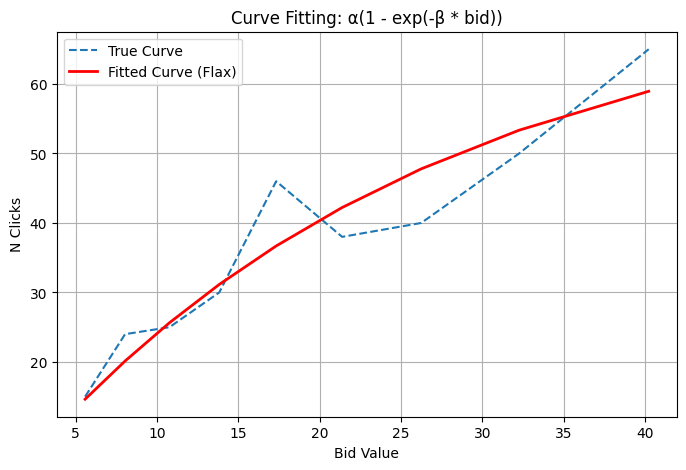

In [32]:
plotChart(X_true,Y_true,Result01['alpha_final'],Result01['beta_final'])

In [ ]:
X_true=ClStreamD02[:,0]
Y_true=ClStreamD02[:,1]
AlphaStart,AlphaEnd=90,100
BetaStart,BetaEnd=0,0.5
Result02=fitCurve(X_true,Y_true,AlphaStart,AlphaEnd,BetaStart,BetaEnd)

Alpha Loop:  15%|█▌        | 3/20 [00:10<00:56,  3.34s/it]

RMSE 55.566558837890625


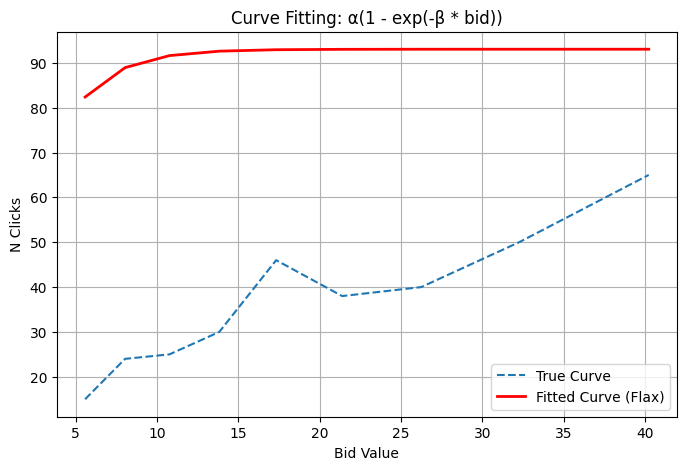

In [36]:
X_true=ClStreamD02[:,0]
Y_true=ClStreamD02[:,1]
plotChart(X_true,Y_true,Result02['alpha_final'],Result02['beta_final'])

In [28]:
X_true=ClStreamD03[:,0]
Y_true=ClStreamD03[:,1]
AlphaStart,AlphaEnd=70,90
BetaStart,BetaEnd=0,0.5
Result03=fitCurve(X_true,Y_true,AlphaStart,AlphaEnd,BetaStart,BetaEnd)

Alpha Loop: 100%|██████████| 20/20 [03:27<00:00, 10.36s/it]


✅ Best Fit Found
Initial α: 90.0, Initial β: 0.10526315867900848
Final α: 92.8575, Final β: 0.0992, Loss: 5.432375


RMSE 35.47021484375


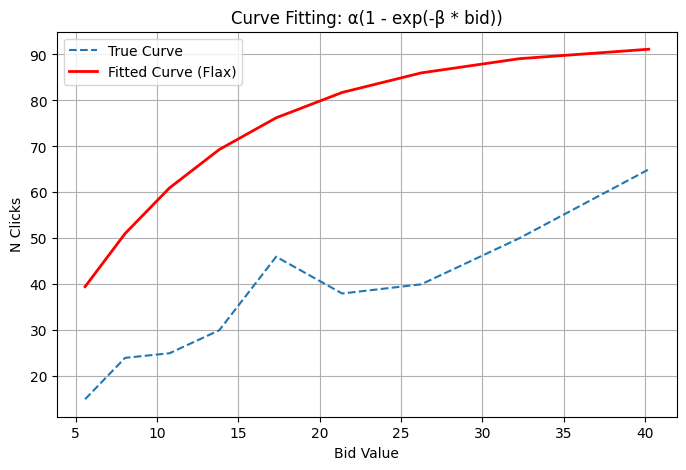

In [35]:
X_true=ClStreamD03[:,0]
Y_true=ClStreamD03[:,1]
plotChart(X_true,Y_true,Result03['alpha_final'],Result03['beta_final'])

In [23]:
import plotly.graph_objs as go
import pandas as pd

# Convert results list to DataFrame
df_results = pd.DataFrame(results)

# Pivot to create grid
pivot = df_results.pivot(index="beta_init", columns="alpha_init", values="final_loss")
x = pivot.columns.values           # alpha values
y = pivot.index.values             # beta values
z = pivot.values                   # loss values (2D)

# Create surface plot
fig = go.Figure(data=[
    go.Surface(
        z=z,
        x=x,
        y=y,
        colorscale='Viridis',
        showscale=True,
        contours={"z": {"show": True, "usecolormap": True}}
    )
])

fig.update_layout(
    title="Loss Surface for Curve Fitting (α, β → Loss)",
    scene=dict(
        xaxis_title="α (alpha_init)",
        yaxis_title="β (beta_init)",
        zaxis_title="Final Loss",
    ),
    autosize=True,
    margin=dict(l=65, r=50, b=65, t=90),
    template="plotly_white"
)

fig.show()